# Parametric ROMs

Look at parametric ROMs by Charbel Farhat. Let's consider a simple example of a static nonlinear beam solver. Something that's easy to code but that we can introduce structural design optimization into it. Let's suppose we want to find the optimal thicknesses to minimize the maximum stress in the beam, with a geometric nonlinear beam formulation of EB theory (we can do Timoshenko later).
* first do this for a simple EB beam problem with hermite cubic elements
* can do this for a plate problem next, fairly simple

## PDE and Optimization Problem
Consider the following linear PDE for steady-state elasticity of a beam.
$$ EI(x) \frac{d^4 w}{dx^4} = q(x) $$
where $x \in [0, L]$ and $q(x) = sin(4 \pi x / L)$ a sinusoidal distributed loading on the beam. The thickness distribution $h(x)$ is given by a set of unit step functions where $x_i$ are the thickness design variables at each station for $N$ total stations.
$$h(x) = \sum_{i=1}^N x_i u_{[i \Delta x, (i+1) \Delta x]}(x) $$
The thickness design variables in each station affect the $EI$ material property as follows:
$$ (EI)_i = E b x_i^3 / 12 $$
The optimization problem is to minimize the mass $M(x)$ with a stress constraint $\sigma_{KS}(x)$ on the whole structure.
$$ \min_{x} M(x) $$
$$ \textrm{s.t. } \sigma_{KS}(x) \leq 1$$

* The mass is computed as $M(x) = \sum_i \rho b x_i \Delta x$.
* The stress in each component is found as $\sigma_{i} = |E (\frac{x_i}{2}) \frac{\partial^2 w}{\partial x^2}((i+1/2)\Delta x)|$. We will just use the stress at the middle of the component for simplicity now, not the max among the whole component, although you could do that too with extra discretization.
* The maximum stress is then found as $\sigma_{KS} = c_{KS}(\sigma_i; \rho_{KS})$ the KS function for a smooth, conservative maximum estimate.

## Adjoint Method for Derivatives
To optimize this, we will need to enforce the discretized form of the PDE:
$$ K(x) \cdot u = F$$
With the adjoint method to get design derivatives if the number of $x$ is much larger than the number of $u$ DOF.
* let's code up the linear static analysis and preliminary optimization before we move onto a ROM. 
* To solve the adjoint method we solve for each function $f$:
$$ K^T \psi = - \frac{\partial f}{\partial u} $$
* Then the total derivatives of each function $f$ are:
$$ \frac{df}{dx} = \frac{\partial f}{\partial x} + \psi^T \frac{\partial R}{\partial x} $$

## Linear Static Analysis
* For the linear static analysis we compute the weak form of the PDE (which is simplified using integration by parts) using test functions $\phi_j(x)$ and a decomposition $w(x) = \sum_i w_i \phi_i(x)$ in each element.
$$ \int EI \frac{d^2 w}{dx^2} \frac{d^2 \phi_j}{dx^2} dx = \int q(x) \phi_j(x) dx $$
* Applying the decomposition within the element we have:
$$ \sum_i \left[ \int EI(x) \frac{d^2 \phi_i}{dx^2} \frac{d^2 \phi_j}{dx^2} dx \right] \cdot u_i = \int q(x) \phi_j(x) dx $$
* this can be written as the linear system:
$$ \sum_{i} K_{ij} u_i = f_j $$
* the element stiffness matrix is of course then $K_e$ over element basis functions:
$$ K_{ij}^e = \int EI(x) \frac{d^2 \phi_i}{dx^2} \frac{d^2 \phi_j}{dx^2} dx $$
* and we find the integral using Gauss quadrature:
$$ K_{ij}^e \approx \sum_q w_q EI(x)_q \phi_{i,xx}(x_q) \phi_{j,xx}(x_q) $$

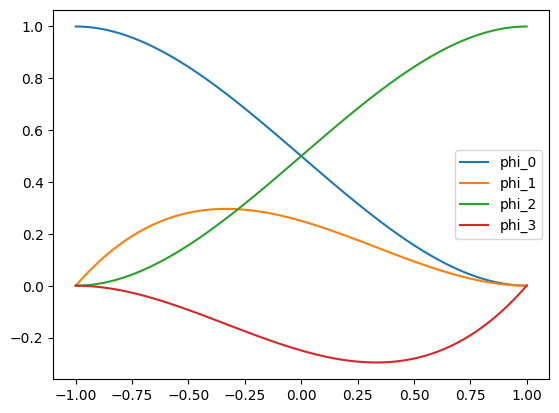

In [1]:
# plot the 1d hermite cubic elements
import sys
sys.path.append("utils/beam-fea")
from beam_elem import plot_hermite_cubic
plot_hermite_cubic()

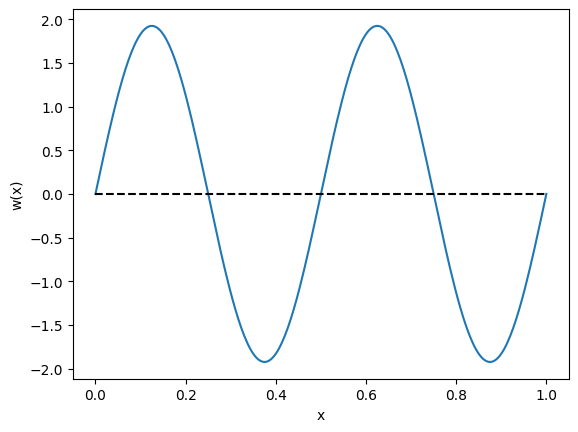

In [2]:
# now let's test this out and visualize it
import sys, numpy as np
sys.path.append("utils/beam-fea")
from solver import BeamFem

E = 2e7; b = 4e-3; L = 1; rho = 1
qmag = 2e-2
ys = 4e5

# scaling inputs
# if rho_KS was too high like 500, then the constraint was too nonlinear or close to max and optimization failed
rho_KS = 50.0 # rho = 50 for 100 elements, used 500 later
nxe = num_elements = int(3e2) #100, 300, 1e3
nxh = 20

hvec = np.array([1e-3] * nxh)

beam_fea = BeamFem(nxe, nxh, E, b, L, rho, qmag, ys, rho_KS, dense=False)
beam_fea.solve_forward(hvec)
beam_fea.plot_disp()

In [3]:
# ok great now let's test the derivatives 
beam_fea.solve_forward(hvec)
beam_fea.solve_adjoint(hvec)
funcs = beam_fea.get_functions(hvec)
func_grads = beam_fea.get_function_gradients(hvec)

helem_vec = beam_fea.get_helem_vec(hvec)
stresses = beam_fea._compute_stresses(helem_vec)
max_stress = np.max(stresses)
print(f"{max_stress=}")

# print values, etc. at nominal design
print(f"mass: {funcs[0]}")
print(f"stress: {funcs[1]}")
# print(f"mass_grad: {func_grads[0,:10]=}")
# print(f"stress_grad: {func_grads[1,:10]=}")

# do complex step test here..
beam_fea.complex_step_test(hvec)

# other debug derivatives tests if needed (all pass now)
# beam_fea.test_dRdx(hvec)
# beam_fea.test_dsdu(hvec)
# beam_fea.test_dsdx(hvec)

max_stress=3.608079130460942
mass: 24000.0
stress: 3.6587833632029807
func_grads.shape=(2, 20)
adj_prods=[11205184.967504397, -10248.481140112157]
cs_prods=[11205184.967504414, -10248.481294002579]


In [4]:
# then we'll apply this in an optimization problem with HDM (high fidelity)
# from scipy.optimize import minimize, NonlinearConstraint
from pyoptsparse import SNOPT, Optimization
import os

run_full_opt = True

def objfunc(xdict):
    x = xdict["x"]
    # print(f"{x=}")
    beam_fea.solve_forward(x)
    funcs = beam_fea.get_functions(x)
    # print(f"{funcs=}")
    funcs = {
        "obj" : funcs[0],
        "stress" : funcs[1],
    }
    return funcs, False

def sens(xdict, funcs):
    x = xdict["x"]
    beam_fea.solve_adjoint(x)
    func_grads = beam_fea.get_function_gradients(x)
    funcsSens = {
        "obj" : { "x" : func_grads[0,:]},
        "stress" : { "x" : func_grads[1,:]},
    }
    return funcsSens, False

# Optimization Object
optProb = Optimization("Beam HFD opt", objfunc)

# Design Variables
x0 = hvec
optProb.addVarGroup("x", nxh, lower=1e-4, upper=None, value=hvec, scale=100.0)

# Functions
optProb.addObj("obj", scale=1e-2)
optProb.addCon("stress", upper=1.0)

# Check optimization problem:
# print(optProb)

# Optimizer
# these are some really good SNOPT settings (use these)
SNOPT_options = {
    "Print frequency": 1000,
    "Summary frequency": 10000000,
    "Major feasibility tolerance": 1e-6,
    "Major optimality tolerance": 1e-3,
    "Verify level": 0,
    "Major iterations limit": 15000 if run_full_opt else 10,
    "Minor iterations limit": 150000000,
    "Iterations limit": 100000000,
    # "Major step limit": 5e-2, # had this off I think (but this maybe could be on)
    "Nonderivative linesearch": True,  # turns off derivative linesearch
    "Linesearch tolerance": 0.9,
    "Difference interval": 1e-6,
    "Function precision": 1e-10,
    "New superbasics limit": 2000,
    "Penalty parameter": 1.0,  # had this off for faster opt in the single panel case
    # however ksfailure becomes too large with this off. W/ on merit function goes down too slowly though
    # try intermediate value btw 0 and 1 (smaller penalty)
    # this may be the most important switch to change for opt performance w/ ksfailure in the opt
    # TODO : could try higher penalty parameter like 50 or higher and see if that helps reduce iteration count..
    #   because it often increases the penalty parameter a lot near the optimal solution anyways
    "Scale option": 1,
    "Hessian updates": 40,
    'Proximal iterations limit' : 0, # turn this off so it doesn't clip linear bounds
    "Print file": os.path.join(f"SNOPT_print.out"),
    "Summary file": os.path.join(f"SNOPT_summary.out"),
}
opt = SNOPT(options=SNOPT_options)
sol = opt(optProb, sens=sens)

# Check Solution
print(sol)



Optimization Problem -- Beam HFD opt
    Objective Function: objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   16.1913
       User Objective Time :       7.9925
       User Sensitivity Time :     8.1055
       Interface Time :            0.0685
       Opt Solver Time:            0.0248
    Calls to Objective Function :     134
    Calls to Sens Function :           45


   Objectives
      Index  Name            Value
          0  obj     3.001156E+04

   Variables (c - continuous, i - integer, d - discrete)
      Index  Name   Type      Lower Bound            Value      Upper Bound     Status
          0  x_0       c     1.000000E-02     1.058435E-01     1.000000E+20           
          1  x_1       c     1.000000E-02     1.361504E-01     1.000000E+20           
          2  x_2       c     1.000000E-02     1.412533E-01     1.000000E+20           
          3  x_3       c     1.000000E-02     1

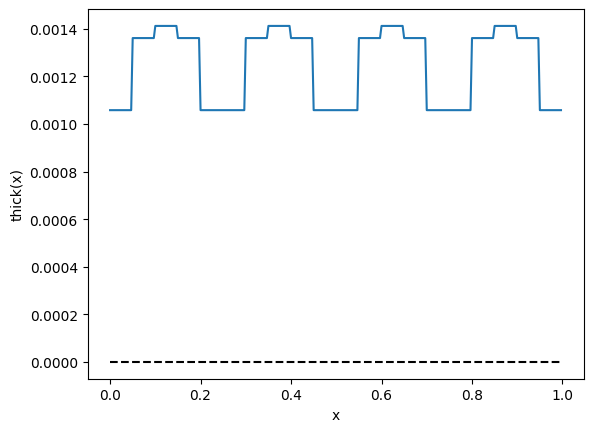

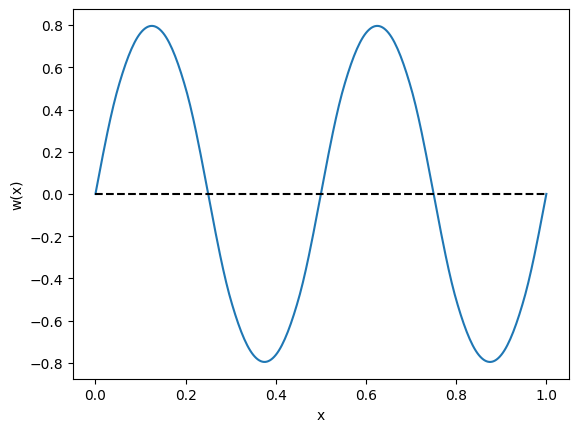

In [5]:
# show the final thickness distribution
hvec_opt = sol.xStar['x']
# print(hvec_opt)
beam_fea.plot_thickness(hvec_opt)

# also the final deformation
beam_fea.plot_disp()